# Beat_1에서 Wavelet과 normalize 적용 시킨 모델

### 모듈, 라이브러리

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import itertools
import collections
from IPython.display import display
from keras import backend as K
%matplotlib inline

#### Default Graph 설정

In [2]:
plt.rcParams["figure.figsize"] = (30, 6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True

#### Train, Test, 평가, Confusion Matrix 함수 구성

In [3]:
def get_train_inputs() :
    x = tf.constant(X_train)
    y = tf.constant(y_train)
    return x, y

def get_test_inputs() :
    x = tf.constant(X_test)
    y = tf.constant(y_test)
    return x, y

def get_evel_data() :
    return tf.constant(X_test)

def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues) :
    
    if normalize : 
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else :
        print("Confusion matrix, without normalization")
        
    plt.figure()
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
            

### SuperClass
* N(Normal) : N L R

* SVEB(SupraVentricular Ectopic Beat) : A a J S e j

* VEB(Ventricular Ectopic Beat) : V E

* F(Fusion beat) : F

* Q(Unknown Beat) : P / f u

In [4]:
for dirname, _, filenames in os.walk('./input/') :
    for filename in filenames :
        print(os.path.join(dirname, filename))

./input/mitbih_database\100.csv
./input/mitbih_database\100annotations.txt
./input/mitbih_database\101.csv
./input/mitbih_database\101annotations.txt
./input/mitbih_database\102.csv
./input/mitbih_database\102annotations.txt
./input/mitbih_database\103.csv
./input/mitbih_database\103annotations.txt
./input/mitbih_database\104.csv
./input/mitbih_database\104annotations.txt
./input/mitbih_database\105.csv
./input/mitbih_database\105annotations.txt
./input/mitbih_database\106.csv
./input/mitbih_database\106annotations.txt
./input/mitbih_database\107.csv
./input/mitbih_database\107annotations.txt
./input/mitbih_database\108.csv
./input/mitbih_database\108annotations.txt
./input/mitbih_database\109.csv
./input/mitbih_database\109annotations.txt
./input/mitbih_database\111.csv
./input/mitbih_database\111annotations.txt
./input/mitbih_database\112.csv
./input/mitbih_database\112annotations.txt
./input/mitbih_database\113.csv
./input/mitbih_database\113annotations.txt
./input/mitbih_database\1

In [5]:
path = './input/mitbih_database/'
window_size = 160 # 160에서 변경
maximum_counting = 100000 # 10000에서 수정. 너무 큰 값이라 undersampling 한 듯.

class_N = ['N', 'L', 'R']
class_SVEB = ['A', 'a', 'J', 'S', 'e', 'j']
class_VEB = ['V', 'E']
class_F = ['F']
class_Q = ['P', '/', 'f', 'u']

classes = class_N + class_SVEB + class_VEB + class_F + class_Q

n_classes = len(classes) # class 개수
count_classes = [0]*n_classes # 각 class 별 개수를 list 로

X = list()
y = list()
print(classes)
print(n_classes)
print(count_classes)

['N', 'L', 'R', 'A', 'a', 'J', 'S', 'e', 'j', 'V', 'E', 'F', 'P', '/', 'f', 'u']
16
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = []
annotations = []
filenames.sort()

In [7]:
for f in filenames :
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv') :
        records.append(path + filename + file_extension)
        
    # *.txt
    else :
        annotations.append(path + filename + file_extension)

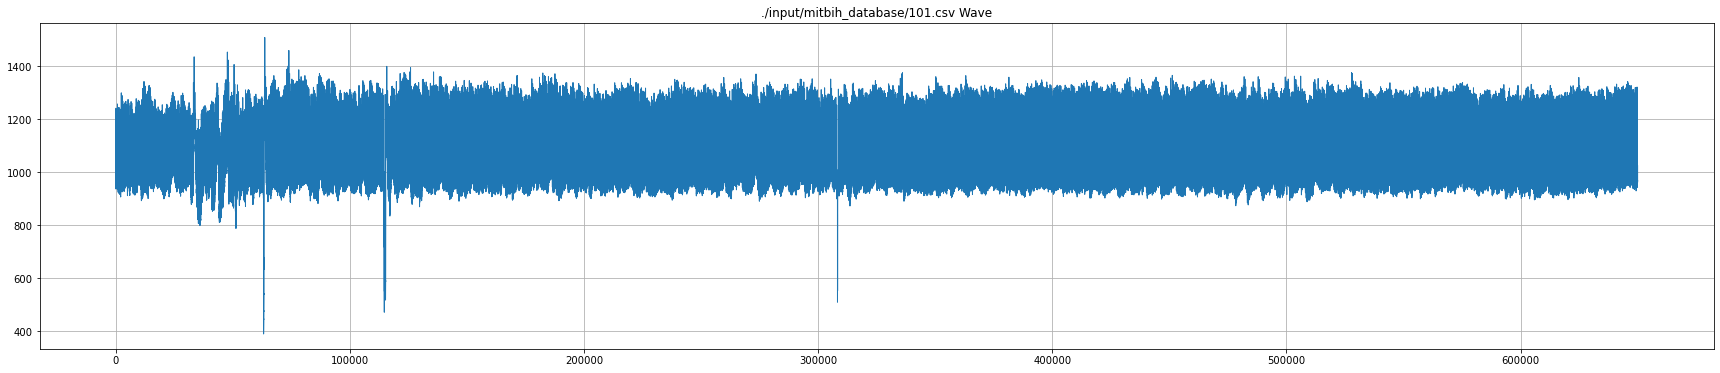

In [8]:
# Records
for r in range(0,len(records)):
# for r in range(2, 3):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals)
        plt.show()

    # Read anotations: R position and Arrhythmia class
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes): # 
                arrhythmia_index = classes.index(arrhythmia_type)
                if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                    pass
                else:
                    count_classes[arrhythmia_index] += 1
                    if(window_size < pos and pos < (len(signals) - window_size)):
                        beat = signals[pos-window_size+1:pos+window_size]
                        X.append(beat)
                        y.append(arrhythmia_index)

In [9]:
for i in range(0,len(X)):
        X[i].append(y[i])

print(np.shape(X))

(109408, 320)


##### Class 별 확인

In [10]:
# representation of classes % wise
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)

0     75014
1      8071
2      7255
9      7129
13     7023
3      2546
14      982
11      802
8       229
4       150
10      106
5        83
7        16
6         2
Name: 319, dtype: int64


In [11]:
print(count_classes) # 왜 per_class보다 개수가 줄어드는가?

[75052, 8075, 7259, 2546, 150, 83, 2, 16, 229, 7130, 106, 803, 0, 7028, 982, 0]


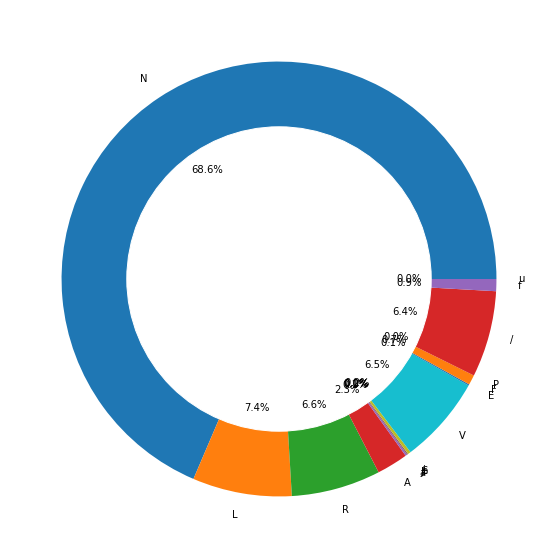

In [12]:
plt.figure(figsize = (20, 10))
my_circle=plt.Circle( (0,0), 0.7, color = 'white')
plt.pie(count_classes, labels = classes, autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

##### SuperClass 별 확인

In [13]:
count_superClasses = [0] * 5
superClasses = ['N', 'SVEB', 'VEB', 'F', 'Q']

In [14]:
class_N = ['N', 'L', 'R'] # 0 1 2
count_superClasses[0] = count_classes[0] + count_classes[1] + count_classes[2]

class_SVEB = ['A', 'a', 'J', 'S', 'e', 'j'] # 3 4 5 6 7 8
count_superClasses[1] = count_classes[3] + count_classes[4] + count_classes[5] + count_classes[6] + count_classes[7] + count_classes[8] 

class_VEB = ['V', 'E'] # 9 10
count_superClasses[2] = count_classes[9] + count_classes[10]

class_F = ['F'] # 11
count_superClasses[3] = count_classes[11]

class_Q = ['P', '/', 'f', 'u'] # 12 13 14 15
count_superClasses[4] = count_classes[12] + count_classes[13] + count_classes[14] + count_classes[15]

In [15]:
print(count_superClasses)

print(sum(count_superClasses))

n_superClasses = len(superClasses)
print(n_superClasses)

[90386, 3026, 7236, 803, 8010]
109461
5


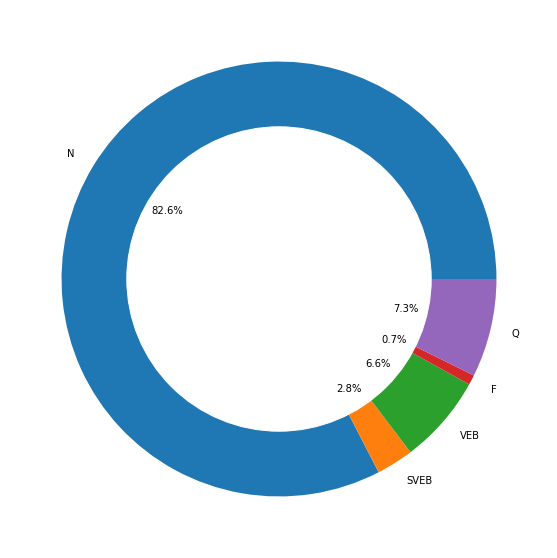

In [16]:
plt.figure(figsize = (20, 10))
my_circle=plt.Circle( (0,0), 0.7, color = 'white')
plt.pie(count_superClasses, labels = superClasses, autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [30]:
maximum_counting = 10000

for i in range(n_superClasses) :
    if(count_superClasses[i] > maximum_counting) :
        count_superClasses[i] = maximum_counting
        
print(count_superClasses)        

[10000, 3026, 7236, 803, 8010]


## Test Size 조정 8:2 , 7:3 둘 다 적용 후 더 나은 것!!!

In [31]:
# Train Test Split
train, test = train_test_split(X_train_df, test_size = 0.20) 

print("X_train : ", len(train))
print("X_test : ", len(test))

X_train :  87526
X_test :  21882


In [32]:
target_train = train[train.shape[1] - 1]
target_test = test[test.shape[1] - 1]
y_train = to_categorical(target_train)
y_test = to_categorical(target_test)
print(np.shape(y_train), np.shape(y_test))

(87526, 15) (21882, 15)


In [33]:
X_train = train.iloc[:,:train.shape[1]-1].values
X_test = test.iloc[:,:test.shape[1]-1].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
print("X_train shape : ", np.shape(X_train))
print("Y_train shape : ", np.shape(y_train))

X_train shape :  (87526, 319, 1)
Y_train shape :  (87526, 15)


In [34]:
a = tf.keras.utils.to_categorical([0, 1, 2, 3], num_classes = 4)
a = tf.constant(a, shape = [4, 4])

In [35]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    f1_precision = precision(y_true, y_pred)
    f1_recall = recall(y_true, y_pred)
    return 2*((f1_precision*f1_recall)/(f1_precision+f1_recall+K.epsilon()))

In [36]:
# Network
def network(X_train, y_train, X_test, y_test) :
    im_shape = (X_train.shape[1], 1)
    
    inputs_cnn = Input(shape = (im_shape), name = 'inputs_cnn')
    # convolutional layer 1
    conv1_1 = Convolution1D(64, (6), activation = 'elu', input_shape = im_shape)(inputs_cnn)
    conv1_1 = BatchNormalization()(conv1_1)
    # pooling layer 1
    pool1 = MaxPool1D(pool_size = (3), strides = (2), padding = "same")(conv1_1)
    # convolutional layer 2
    conv2_1 = Convolution1D(128, (3), activation = 'elu', input_shape = im_shape)(pool1)
    conv2_1 = BatchNormalization()(conv2_1)
    # convolutional layer 3
    conv3_1 = Convolution1D(128, (3), activation = 'elu', input_shape = im_shape)(conv2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    # pooling layer 2
    pool2 = MaxPool1D(pool_size = (2), strides = (2), padding = 'same')(conv3_1)
    # convolutional layer 4
    conv4_1 = Convolution1D(256, (3), activation = 'elu', input_shape = im_shape)(pool2)
    conv4_1 = BatchNormalization()(conv4_1)
    # convolution layer 5
    conv5_1 = Convolution1D(256, (3), activation = 'elu', input_shape = im_shape)(conv4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    # pooling layer 3
    pool3 = MaxPool1D(pool_size = (2), strides = (2), padding = "same")(conv5_1)
    # flattened layer 1
    flatten = Flatten()(pool3)
    # dense layer
    dense_end1 = Dense(1024, activation = 'elu')(flatten)
    
    main_output = Dense(15, activation = 'softmax', name = 'main_output')(dense_end1)
    
    model = Model(inputs = inputs_cnn, outputs = main_output)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', recall, precision, f1])
    
    callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2), ModelCheckpoint(filepath = 'best_model.h5', monitor = 'val_loss', save_best_only = True)]
    
    history = model.fit(X_train, y_train, epochs = 5, callbacks = callbacks, batch_size = 32, validation_data = (X_test, y_test))
    model.load_weights('best_model.h5')
    return(model, history)
    

In [37]:
def evaluate_model(history, X_test, y_test, model) :
    scores = model.evaluate((X_test), y_test, verbose = 0)
    print("Accuracy : %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc = 'lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model - Loss')
    plt.legend(['Training', 'Validation'], loc = 'upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_name = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'
                  '10', '11', '12', '13', '14', '15']
    
    y_true = []
    for element in y_test :
        y_true.append(np.argmax(element))
    prediction_proba = model.predict(X_test)
    prediction = np.argmax(prediction_proba, axis = 1)
    cnf_matrix = confusion_matrix(y_true, prediction)  

### 모델 학습

In [38]:
print(np.shape(X_train))
print(np.shape(X_test))

(87526, 319, 1)
(21882, 319, 1)


In [39]:
train_samples, train_x, _ = np.shape(X_train)
X_train = X_train.reshape((train_samples, train_x))

test_samples, test_x, _ = np.shape(X_test)
X_test = X_test.reshape((test_samples, test_x))

In [41]:
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()
print(minMaxScaler.fit(X_train))
X_train = minMaxScaler.transform(X_train)
X_test = minMaxScaler.transform(X_test)

MinMaxScaler()


In [42]:
import pywt
(X_train, X_train2) = pywt.dwt(X_train, 'db1')
(X_test, X_test2) = pywt.dwt(X_test, 'db1')


In [43]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
model, history = network(X_train, y_train, X_test, y_test)


Epoch 1/5
2736/2736 [==============================] - 225s 82ms/step - loss: 0.1850 - accuracy: 0.9621 - recall: 0.9604 - precision: 0.9649 - f1: 0.9625 - val_loss: 0.1433 - val_accuracy: 0.9688 - val_recall: 0.9680 - val_precision: 0.9702 - val_f1: 0.9691
Epoch 2/5
2736/2736 [==============================] - 233s 85ms/step - loss: 0.1037 - accuracy: 0.9795 - recall: 0.9789 - precision: 0.9802 - f1: 0.9795 - val_loss: 1.2635 - val_accuracy: 0.8178 - val_recall: 0.8154 - val_precision: 0.8204 - val_f1: 0.8179
Epoch 3/5
2736/2736 [==============================] - 234s 86ms/step - loss: 0.0928 - accuracy: 0.9816 - recall: 0.9813 - precision: 0.9822 - f1: 0.9818 - val_loss: 2.0151 - val_accuracy: 0.7545 - val_recall: 0.7529 - val_precision: 0.7575 - val_f1: 0.7552


Accuracy : 96.88%


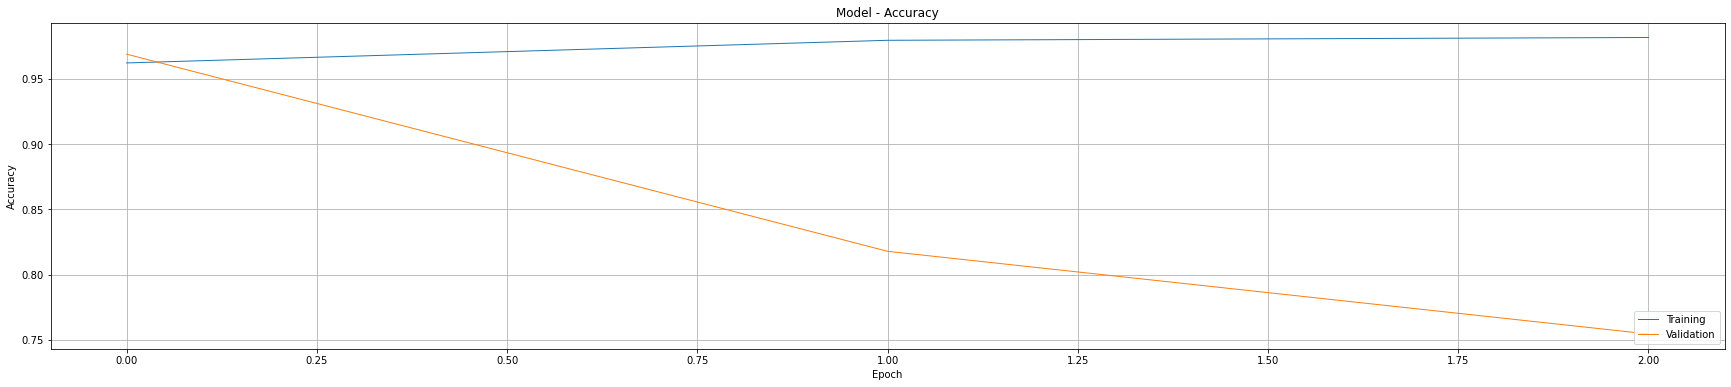

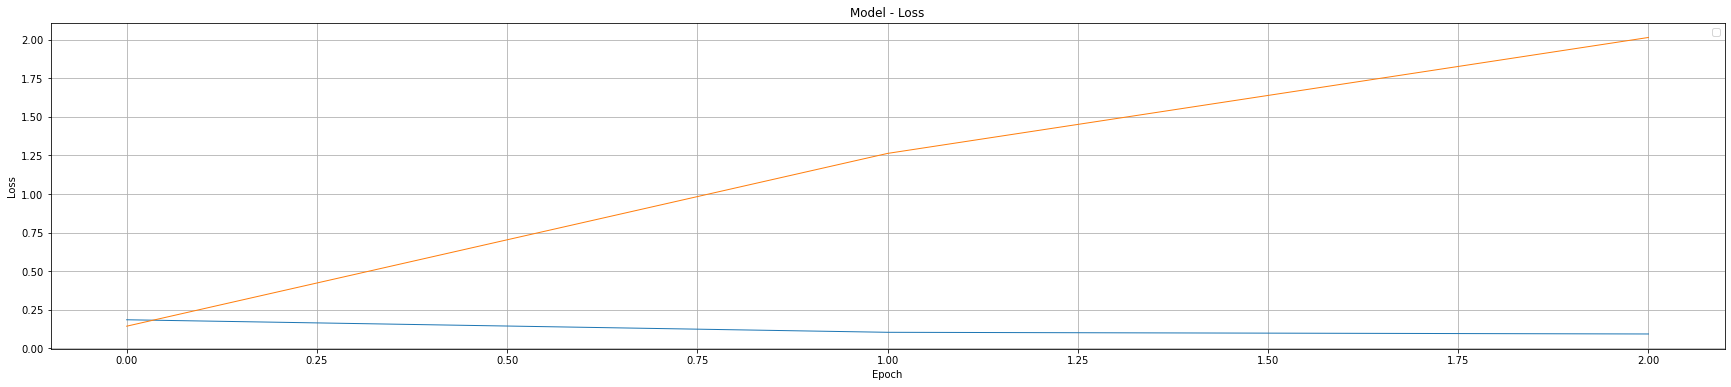

In [44]:
evaluate_model(history, X_test, y_test, model)
y_pred = model.predict(X_test)

In [45]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues) :
    if normalize :
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else : 
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.xlabel('True label')
        plt.ylabel('Predicted label')
        


<ipython-input-45-014c42c72d7e>:4: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]


Normalized confusion matrix


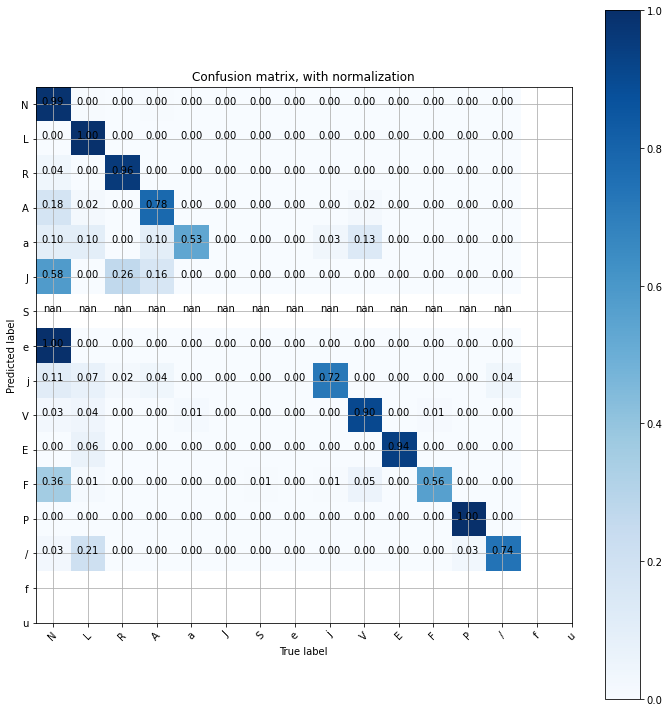

In [46]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
np.set_printoptions(precision = 2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (10, 10))
plot_confusion_matrix(cnf_matrix, classes = ['N', 'L', 'R', 'A', 'a', 'J', 'S', 'e', 'j', 'V', 'E', 'F', 'P', '/', 'f', 'u'], normalize = True, title = 'Confusion matrix, with normalization')
plt.show()

In [ ]:
# 0     75014
# 1      8071
# 2      7255
# 9      7129
# 13     7023
# 3      2546
# 14      982
# 11      802
# 8       229
# 4       150
# 10      106
# 5        83
# 7        16
# 6         2